# HR Analytics Challenge

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

#### Reading data

In [2]:
data= pd.read_csv(r'Desktop\HR_Analytics_Vidhya_Comp\train.csv')
test= pd.read_csv(r'Desktop\HR_Analytics_Vidhya_Comp\test.csv')

## Checking the dataset

In [3]:
data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [4]:
test.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


In [5]:
data['is_promoted'].value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

In [6]:
print ('The Test data shape:', test.shape)
print ('The Train data shape:', data.shape)

The Test data shape: (23490, 13)
The Train data shape: (54808, 14)


In [7]:
data.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [8]:
train_total = data.isnull().sum()
train_percent = ((data.isnull().sum()/data.shape[0])*100).round(2)
test_total = test.isnull().sum()
test_percent = ((test.isnull().sum()/test.shape[0])*100).round(2)
train_missing_data = pd.concat([train_total, train_percent, test_total, test_percent],
                                axis=1, 
                                keys=['Train_Total', 'Train_Percent %','Test_Total', 'Test_Percent %'],
                                sort = True)
train_missing_data.style.background_gradient(cmap = 'copper')

,Train_Total,Train_Percent %,Test_Total,Test_Percent %
KPIs_met >80%,0,0.000000,0.000000,0.000000
age,0,0.000000,0.000000,0.000000
avg_training_score,0,0.000000,0.000000,0.000000
awards_won?,0,0.000000,0.000000,0.000000
department,0,0.000000,0.000000,0.000000
education,2409,4.400000,1034.000000,4.400000
employee_id,0,0.000000,0.000000,0.000000
gender,0,0.000000,0.000000,0.000000
is_promoted,0,0.000000,nan,nan
length_of_service,0,0.000000,0.000000,0.000000


In [9]:
data['education']= data['education'].fillna(data['education'].mode()[0])
data['previous_year_rating']= data['previous_year_rating'].fillna(data['previous_year_rating'].mode()[0])

In [10]:
test['education']= test['education'].fillna(test['education'].mode()[0])
test['previous_year_rating']= test['previous_year_rating'].fillna(test['previous_year_rating'].mode()[0])

In [11]:
print("Number of Missing Values Left in the Training Data :", data.isnull().sum().sum())
print("Number of Missing Values Left in the Test Data :", test.isnull().sum().sum())

Number of Missing Values Left in the Training Data : 0
Number of Missing Values Left in the Test Data : 0


In [12]:
data1= data.copy()
test1= test.copy()

#### Creating a Metric of Sum


In [13]:
data1['sum_metric'] = data1['awards_won?']+ data1['KPIs_met >80%'] + data1['previous_year_rating']
test1['sum_metric'] = test1['awards_won?']+test1['KPIs_met >80%'] + test1['previous_year_rating']

####  Creating a total score column

In [14]:
data1['total_score'] = data1['avg_training_score'] * data1['no_of_trainings']
test1['total_score'] = test1['avg_training_score'] * test1['no_of_trainings']

In [15]:
data1 = data1.drop(['recruitment_channel', 'region', 'employee_id'], axis = 1)
test1 = test1.drop(['recruitment_channel', 'region', 'employee_id'], axis = 1)

#### Converting education to Ordinal data

In [16]:
data1['education'] = data1['education'].replace(("Master's & above", "Bachelor's", "Below Secondary"),(3, 2, 1))
test1['education'] = test1['education'].replace(("Master's & above", "Bachelor's", "Below Secondary"),(3, 2, 1))

#### Label Encoding for Gender and Department to convert them into Numerical values

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data1['department'] = le.fit_transform(data1['department'])
test1['department'] = le.fit_transform(test1['department'])
data1['gender'] = le.fit_transform(data1['gender'])
test1['gender'] = le.fit_transform(test1['gender'])

#### Checking on availability of categorical columns after encoding


In [18]:
print(data1.select_dtypes('object').columns)
print(test1.select_dtypes('object').columns)

Index([], dtype='object')
Index([], dtype='object')


## Balancing the data 

Text(0, 0.5, 'Frequency')

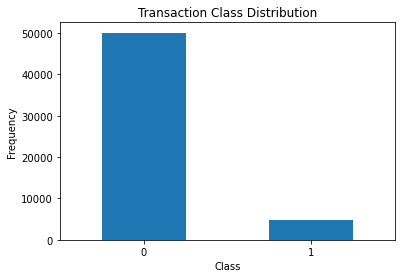

In [19]:
count_classes = pd.value_counts(data['is_promoted'], sort = True)
count_classes.plot(kind = 'bar', rot=1)
plt.title("Transaction Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [20]:
x = data.drop('is_promoted',axis=1)
y = data.loc[:,'is_promoted']

#### Using RandomOverSampler to handle the imbalanced data  

In [21]:
from imblearn.over_sampling import RandomOverSampler

In [22]:
os =  RandomOverSampler(sampling_strategy=0.8)
x_train_res, y_train_res = os.fit_sample(x, y)

In [23]:
x_train_res.shape,y_train_res.shape

((90252, 13), (90252,))

In [24]:
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_train_res)))

Original dataset shape Counter({0: 50140, 1: 4668})
Resampled dataset shape Counter({0: 50140, 1: 40112})


#### Split the target data from the train data

In [25]:
y = data1['is_promoted']
x = data1.drop(['is_promoted'], axis = 1)
x_test = test1

#### Print the shapes of the new data sets

In [26]:
print("Shape of the x :", x.shape)
print("Shape of the y :", y.shape)
print("Shape of the x Test :", x_test.shape)

Shape of the x : (54808, 12)
Shape of the y : (54808,)
Shape of the x Test : (23490, 12)


In [27]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [28]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)
x_test = sc.transform(x_test)

In [29]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

In [30]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score,recall_score, f1_score

In [31]:
print('Accuracy Score is:', accuracy_score(y_valid, y_pred))
print('Recall Score is:', recall_score(y_valid, y_pred))
print('Precision Score:', precision_score(y_valid, y_pred))
print('F1 score is:', f1_score(y_valid, y_pred))

Accuracy Score is: 0.9058565955117679
Recall Score is: 0.43213897937024975
Precision Score: 0.4388092613009923
F1 score is: 0.4354485776805252


In [32]:
from sklearn.svm import SVC
svm=SVC(random_state=1)
svm.fit(x_train,y_train)
y_pred1 = model.predict(x_valid)

In [33]:
print('Accuracy Score is:', accuracy_score(y_valid, y_pred1))
print('Recall Score is:', recall_score(y_valid, y_pred1))
print('Precision Score:', precision_score(y_valid, y_pred1))
print('F1 score is:', f1_score(y_valid, y_pred1))

Accuracy Score is: 0.9058565955117679
Recall Score is: 0.43213897937024975
Precision Score: 0.4388092613009923
F1 score is: 0.4354485776805252


In [34]:
class_names=np.array(['0','1'])
print(classification_report(y_valid, y_pred1, target_names=class_names))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10041
           1       0.44      0.43      0.44       921

    accuracy                           0.91     10962
   macro avg       0.69      0.69      0.69     10962
weighted avg       0.91      0.91      0.91     10962



In [35]:
from sklearn.model_selection import cross_val_score

#### Plotting the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)

In [36]:
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, x, y, cv=10, scoring='accuracy')
print(scores)

[0.92775041 0.92610837 0.9231892  0.92866265 0.92209451 0.92793286
 0.92410144 0.92592593 0.92956204 0.92536496]


In [37]:
print(scores.mean())

0.9260692378581883


## Model selection using Cross Validation 

#### 10-fold cross-validation with logistic regression
 

In [38]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
print(cross_val_score(logreg, x, y, cv=10, scoring='accuracy').mean())

0.915340845681898


#### 10-fold cross-validation with Decision Tree
 

In [39]:
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier()
print(cross_val_score(DTC, x, y, cv=10, scoring='accuracy').mean())

0.8994672105495163


#### 10-fold cross-validation with Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(n_estimators = 100)
print(cross_val_score(RFC, x, y, cv=10, scoring='accuracy').mean())

0.9292803906527792


In [41]:
from sklearn.linear_model import LogisticRegression
Logit_model= LogisticRegression()
Logit_model.fit(x_train, y_train)
y_pred2= Logit_model.predict(x_valid)
print('Accuracy Score is:', accuracy_score(y_valid, y_pred2))
print('Recall Score is:', recall_score(y_valid, y_pred2))
print('Precision Score:', precision_score(y_valid, y_pred2))
print('F1 score is:', f1_score(y_valid, y_pred2))

Accuracy Score is: 0.9191753329684365
Recall Score is: 0.08577633007600434
Precision Score: 0.6422764227642277
F1 score is: 0.15134099616858238


In [42]:
class_names=np.array(['0','1'])
print(classification_report(y_valid, y_pred2, target_names=class_names))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     10041
           1       0.64      0.09      0.15       921

    accuracy                           0.92     10962
   macro avg       0.78      0.54      0.55     10962
weighted avg       0.90      0.92      0.89     10962



In [43]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
rf.fit(x_train,y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=700, n_jobs=-1,
                       oob_score=True, random_state=1)

In [44]:
y_pred3= rf.predict(x_valid)
print('Accuracy Score is:', accuracy_score(y_valid, y_pred3))
print('Recall Score is:', recall_score(y_valid, y_pred3))
print('Precision Score:', precision_score(y_valid, y_pred3))
print('F1 score is:', f1_score(y_valid, y_pred3))

Accuracy Score is: 0.940156905674147
Recall Score is: 0.32356134636264927
Precision Score: 0.9003021148036254
F1 score is: 0.476038338658147


In [45]:
y_pred3= rf.predict(x_test)

In [46]:
test['is_promoted']= y_pred3

In [47]:
test

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,3.0,1,1,0,77,0
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51,0
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47,0
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65,0
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23485,53478,Legal,region_2,Below Secondary,m,sourcing,1,24,3.0,1,0,0,61,0
23486,25600,Technology,region_25,Bachelor's,m,sourcing,1,31,3.0,7,0,0,74,0
23487,45409,HR,region_16,Bachelor's,f,sourcing,1,26,4.0,4,0,0,50,0
23488,1186,Procurement,region_31,Bachelor's,m,sourcing,3,27,3.0,1,0,0,70,0


In [48]:
output=pd.DataFrame(data={"employee_id":test["employee_id"],"is_promoted":test['is_promoted']}) 
output.to_csv(path_or_buf=r"Desktop\HR_Analytics_Vidhya_Comp\output.csv",index=False,quoting=3,)